## Is that suppose to be a shark?!

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -U duckduckgo_search
    !pip install -Uqq fastai
    !pip install fastbook

  Obtaining dependency information for duckduckgo_search from https://files.pythonhosted.org/packages/97/8e/01d4aea1f9fdac45973d2f1d07d29832a243f91106e10d8ffb442adf4f4d/duckduckgo_search-4.2-py3-none-any.whl.metadata
  Obtaining dependency information for curl-cffi>=0.5.10 from https://files.pythonhosted.org/packages/93/04/0d57a51690451437f72563031036ea4f4b529bc0cfd8e8d93487075cbe80/curl_cffi-0.5.10-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 70.2 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 14.3 MB/s eta 0:00:00a 0:00:01


## Step 1: Download images

In [3]:
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *
from fastdownload import download_url

def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(search_images_ddg(term, max_images=max_images))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Searching for 'shark photos'


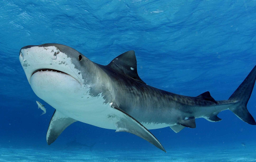

In [4]:
download_url(search_images('shark photos', max_images=1)[0], 'shark.jpg', show_progress=False)
Image.open('shark.jpg').to_thumb(256,256)

Searching for 'diver photos'


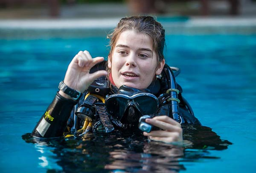

In [5]:
download_url(search_images('diver photos', max_images=1)[0], 'diver.jpg', show_progress=False)
Image.open('diver.jpg').to_thumb(256,256)

In [6]:
searches = ['shark', 'diver']
path = Path('shark_or_not')

if not path.exists():
    path.mkdir()
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        download_images(dest, urls=search_images(f'{o} photos'))

Searching for 'shark photos'
Searching for 'diver photos'


## Step 2: Train our model

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

In [8]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

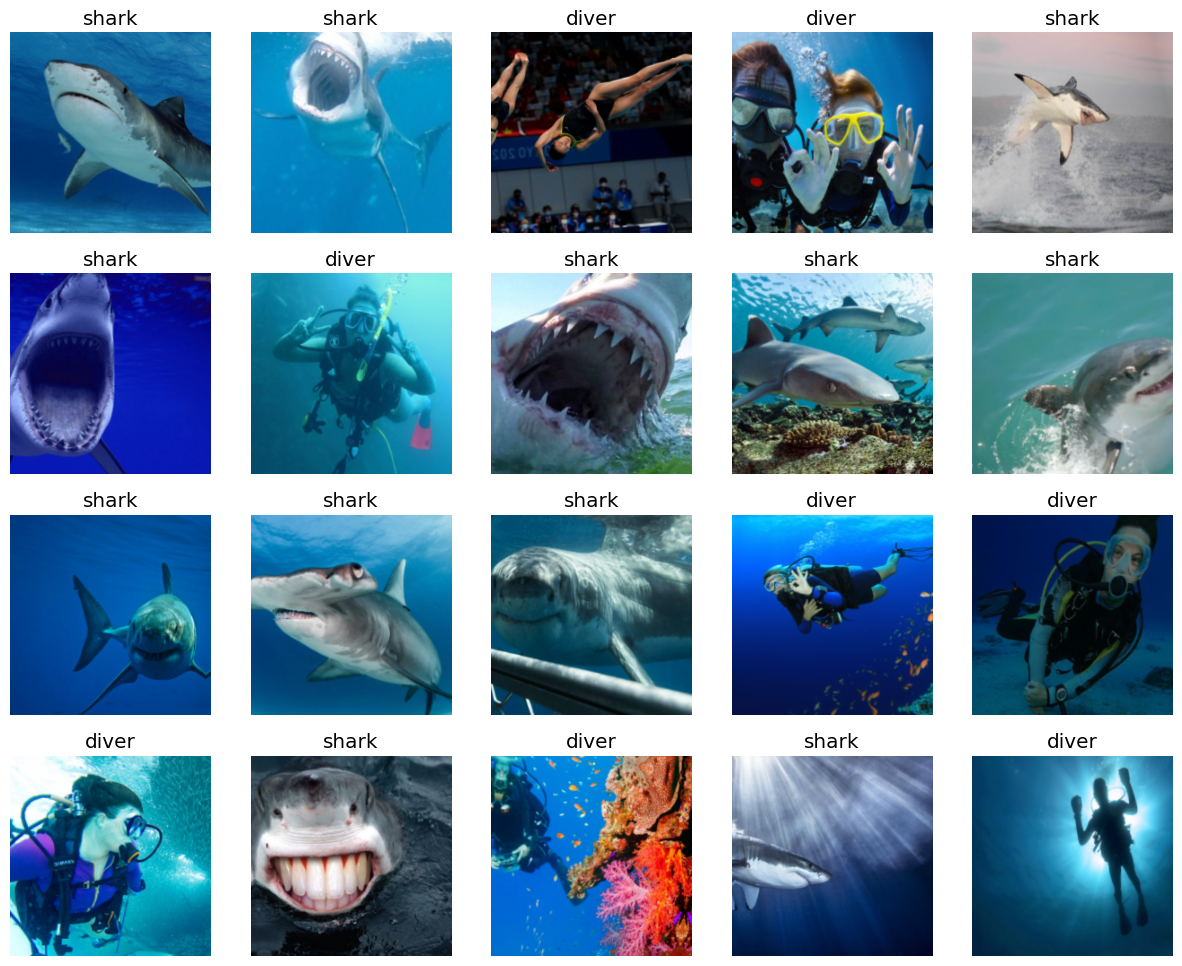

In [9]:
images = images.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = images.dataloaders(path)
dls.show_batch(max_n=20)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,0.802234,1.669255,0.421053,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.381944,0.559862,0.157895,00:10
1,0.243523,0.082952,0.026316,00:09
2,0.179408,0.019200,0.000000,00:10
3,0.134208,0.011047,0.000000,00:10


## Step 3: Use model

In [15]:
is_shark,_,probs = learn.predict(PILImage.create('shark.jpg'))
print(f"This is a: {is_shark}.")
print(f"Probability it's a diver: {probs[0]:.4f}")

This is a: shark.
Probability it's a diver: 0.0000


In [12]:
is_diver,_,probs = learn.predict(PILImage.create('diver.jpg'))
print(f"This is a: {is_diver}.")
print(f"Probability it's a diver: {probs[0]:.4f}")

This is a: diver.
Probability it's a diver: 1.0000


In [13]:
learn.export('model.pkl')

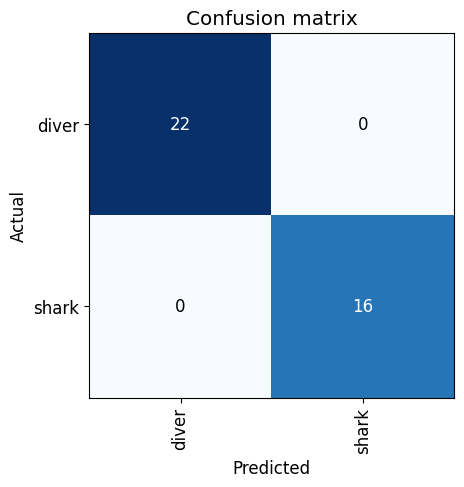

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()